In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm
import xarray as xr
import graphviz as gv

from scipy.interpolate import PchipInterpolator

In [3]:
url_hockey = 'https://raw.githubusercontent.com/anyaweintraub/datasciencefoundationsA3/refs/heads/main/hockeyfull2425.csv'
hockey_data = pd.read_csv(url_hockey,dtype={'Pos':'category'})

In [4]:
hockey_data

,Rk,Player,Age,Team,Pos,GP,G,A,PTS,+/-,...,ATOI,FOW,FOL,FO%,BLK,HIT,TAKE,GIVE,Awards,-9999
0,1,Nikita Kucherov,31.0,TBL,RW,78,37,84,121,22,...,21:11,1,1,50.0,33,23,30,122,ASnhl-1Hart-3Ross-1Pearson-1,kucheni01
1,2,Nathan MacKinnon,29.0,COL,C,79,32,84,116,25,...,22:47,756,758,49.9,58,38,27,121,ASnhl-1Hart-4Selke-29,mackina01
2,3,Leon Draisaitl,29.0,EDM,C,71,52,54,106,32,...,21:31,650,546,54.3,27,23,35,88,ASnhl-2ASnhl-7ASnhl-8Byng-24Hart-2Richard-1Sel...,draisle01
3,4,David Pastrňák,28.0,BOS,RW,82,43,63,106,0,...,20:11,3,5,37.5,24,58,40,118,ASnhl-2Hart-11,pastrda01
4,5,Mitch Marner,27.0,TOR,RW,81,27,75,102,18,...,21:19,10,24,29.4,40,49,56,106,ASnhl-3ASnhl-11Byng-8Hart-13Selke-7,marnemi01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245,1020,Scott Wedgewood,32.0,NSH,G,5,0,0,0,0,...,52:00:00,0,0,NaN,0,0,0,2,NaN,wedgesc01
1246,1020,Scott Wedgewood,32.0,COL,G,19,0,0,0,0,...,58:35:00,0,0,NaN,0,0,0,5,NaN,wedgesc01
1247,1021,Colin White,28.0,SJS,C,3,0,0,0,-1,...,7:18,3,10,23.1,1,2,0,1,NaN,whiteco02
1248,1022,Jack Williams,NaN,CBJ,F,1,0,0,0,1,...,11:09,5,6,45.5,1,0,1,1,NaN,willija02


# Context

In hockey, hitting other players is usually legal. However, there are some hits that will result in time in the penalty box, such as tripping or hitting someone's head.

For my project, I decided to see if the number of legal hits has a correlation to the time a player spends in the penalty box.

Text(0, 0.5, 'PIM')

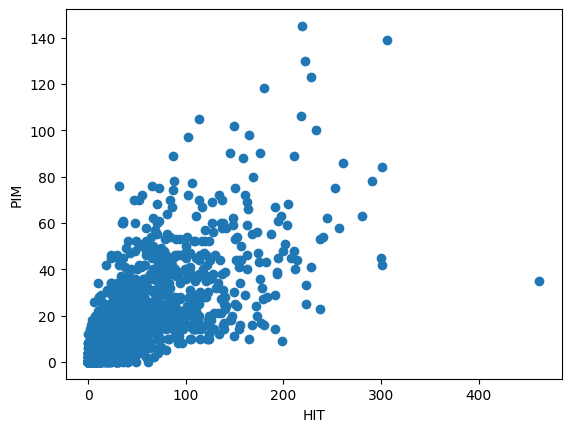

In [ ]:
#make scatter plot of HIT (legal hits) and PIM (penalties in minutes) for NHL players
plt.scatter(hockey_data['HIT'] , hockey_data['PIM'],)

#label axes
plt.xlabel("HIT")
plt.ylabel("PIM")

In [ ]:
#lh stands for linear hockey
with pm.Model() as model_lh:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * hockey_data.HIT)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=hockey_data.PIM)

    #inference data object
    idata_lh = pm.sample()


Text(0, 0.5, 'PIM')

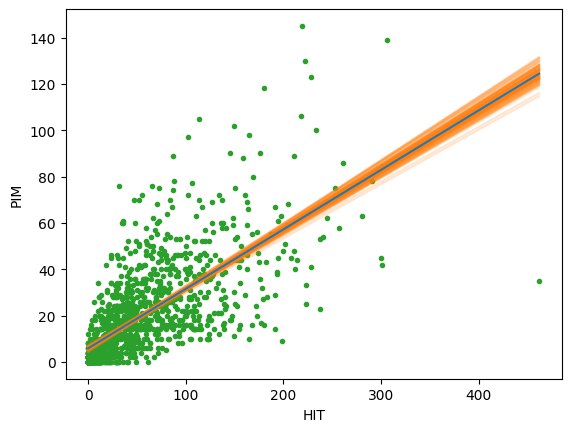

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_lh, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(hockey_data.HIT.min(), hockey_data.HIT.max(), 180),
    dims="plot_id"
    )

# this creates the expected line, the path we predict HIT and PIM deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(hockey_data.HIT, hockey_data.PIM, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("HIT")
ax.set_ylabel("PIM")

In [ ]:
# posterior predictive check
pm.sample_posterior_predictive(idata_lh, model=model_lh,  extend_inferencedata=True)

Text(0, 0.5, 'PIM')

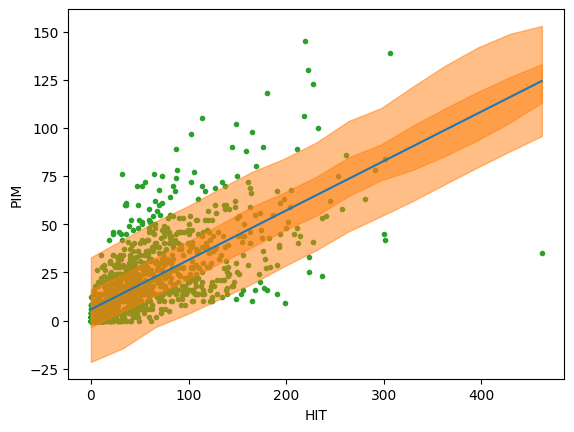

In [ ]:

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_lh.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
HIT = np.random.normal(hockey_data.HIT.values, 0.01)
idx = np.argsort(HIT)
x = np.linspace(HIT.min(), HIT.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_lh.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(HIT[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(hockey_data.HIT, hockey_data.PIM, "C2.", zorder=-3)
ax.plot(hockey_data.HIT[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lh, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lh, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("HIT")
ax.set_ylabel("PIM")

<Axes: xlabel='y_pred'>

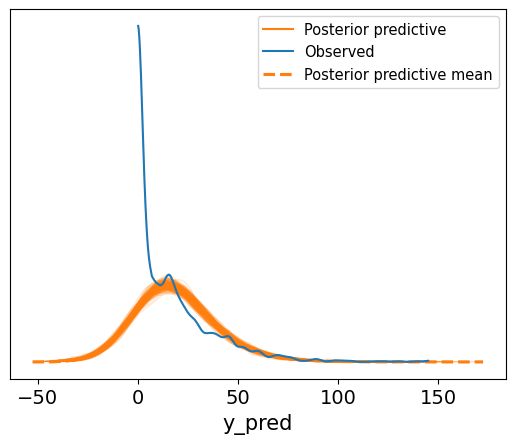

In [ ]:
#posterior predictive check
az.plot_ppc(idata_lh, num_pp_samples=200, colors=["C1", "C0", "C1"])

The second half of the graph is fairly accurate, but not the lower values. I will need to use a model that accounts for a higher number of lower values. Mr. Arredondo suggested I try a variable variance model.

In [ ]:
#vvh for variable variance hockey
with pm.Model() as model_vvh:

    #priors for line for our mean
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #priors for the line for our standard deviation
    γ = pm.HalfNormal("γ", sigma=10)
    δ = pm.HalfNormal("δ", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * hockey_data.HIT)

    #standard deviation line; this allows our variance to vary over th x values
    σ = pm.Deterministic("σ", γ + δ * hockey_data.HIT)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=hockey_data.PIM)

    idata_vvh = pm.sample()

Text(0, 0.5, 'PIM')

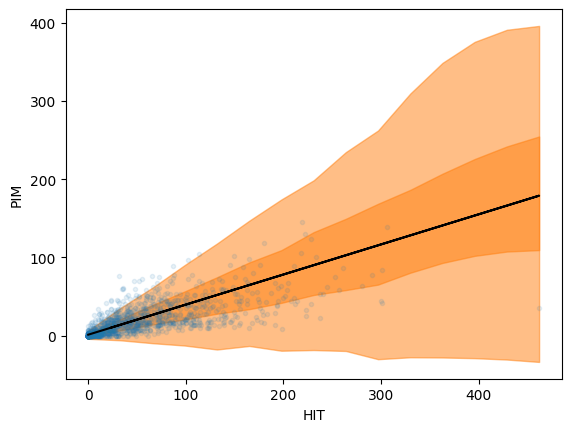

In [11]:
#plots the posterior

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_vvh.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
HIT = np.random.normal(hockey_data.HIT.values, 0.01)
idx = np.argsort(HIT)
x = np.linspace(HIT.min(), HIT.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_vvh.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(HIT[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()

ax.plot(hockey_data.HIT, hockey_data.PIM, "C0.", alpha=0.1)

posterior_vvh = az.extract(idata_vvh)

μ_m = posterior_vvh["μ"].mean("sample").values
σ_m = posterior_vvh["σ"].mean("sample").values

ax.plot(hockey_data.HIT, μ_m, c="k")

#graphs the 94% and 50% HDIs
for lh, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lh, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("HIT")
ax.set_ylabel("PIM")

In [ ]:
#creates our posterior predictive distribution

pm.sample_posterior_predictive(
    idata_vvh, model = model_vvh, extend_inferencedata=True
    )

<Axes: xlabel='y_pred'>

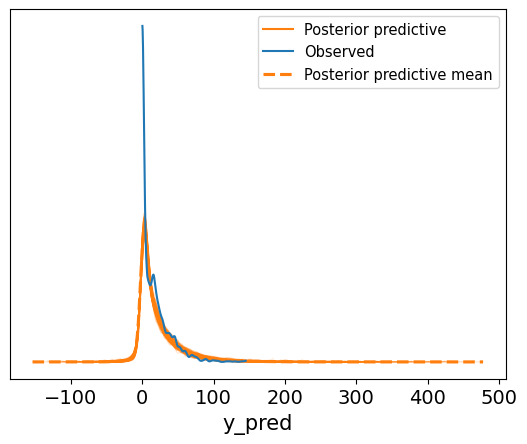

In [ ]:
# posterior predictive check
az.plot_ppc(idata_vvh, num_pp_samples=200, colors=["C1", "C0", "C1"])

This is honestly much more accurate, except for the fact that the data closest to 0 increases. If I had more time I would try using a model with positive support. Using variable variance seems to be the way to go!

# Does position impact the correlation?

In [ ]:
#this is an array of the hockey positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = hockey_data.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = hockey_data.Pos.cat.categories

#puts coords in a dict, so pymc can read them
hockey_coords = {"pos": pos_codes}

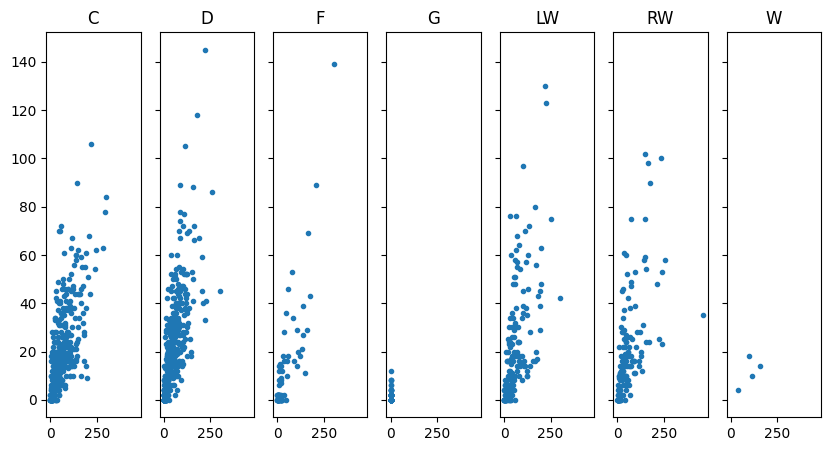

In [ ]:
#set up the 7 plots
_, ax = plt.subplots(1, 7, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = hockey_data.query('Pos == @p')['HIT'],
        y =  hockey_data.query('Pos == @p')['PIM'],
        marker=".")
    ax[i].set_title(f"{p}")

In [ ]:
#nh for non hierarchical
with pm.Model(coords=hockey_coords) as nh_model:




    #priors
    α = pm.Normal("α", mu=0, sigma=3, dims="pos")
    β = pm.Normal("β", mu=0, sigma=10, dims="pos")
    σ = pm.HalfNormal("σ", 1)

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * hockey_data['HIT'],
                  sigma=σ,
                  observed=hockey_data['PIM'])
    idata_nh = pm.sample()

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/

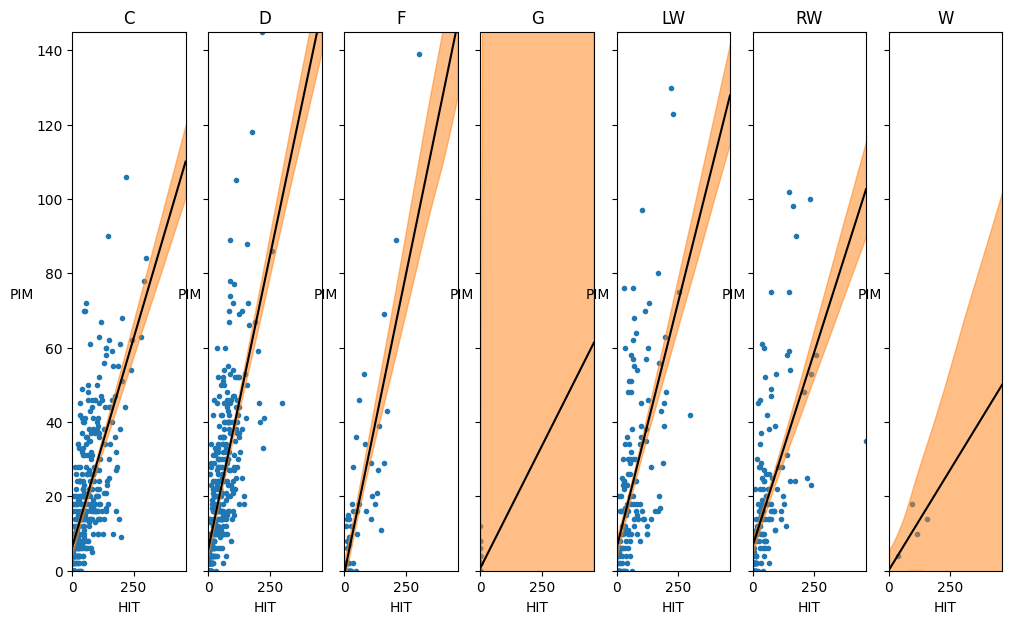

In [ ]:
#set out our 7 plots
_, ax = plt.subplots(1, 7, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)

#set up x values. Used to graph line of best fit
x_range = np.linspace(hockey_data['HIT'].min(), hockey_data['HIT'].max(), 10)

#grab posterior info
posterior = az.extract(idata_nh)

#for each position
for i, p in enumerate(pos_codes):
    #plot the raw data
    ax[i].scatter(
        x = hockey_data.query('Pos == @p')['HIT'],
        y = hockey_data.query('Pos == @p')['PIM'],
        marker=".")

    #gives our graphs titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("HIT")
    ax[i].set_ylabel("PIM", labelpad=10, rotation=0)

    #grab the slope and y-int
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()

    #plot the mean line, or line of best fit
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")

    #plot a 94% HDI of the line of best fit.
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])

    #set the limits of our graphs' window
    plt.xlim(hockey_data['HIT'].min() - 0.01, hockey_data['HIT'].max() + 0.01)
    plt.ylim(hockey_data['PIM'].min() - 0.01, hockey_data['PIM'].max() + 0.01)

Overall it's not doing a great job of encompassing the data.

In [ ]:
#hoff for hierarchical offset
with pm.Model(coords=hockey_coords) as hoff_model:
    # hyper-priors
    α_μ = pm.Normal("α_μ", 0, sigma=3)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=3)
    β_σ = pm.HalfNormal("β_σ", sigma=5)

    # priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="pos")
    σ = pm.HalfNormal("σ", 5)

    #prior of beta is different; now, we predict how far our guess is from the
    #overall average
    β_offset = pm.Normal("β_offset", mu=0, sigma=3, dims="pos")
    β = pm.Deterministic("β", β_μ + β_offset * β_σ, dims="pos")

    #likelihood
    #the linear part of the model is put directly into mu
    y = pm.Normal("y_pred",
                  mu=α[pos_idx] + β[pos_idx] * hockey_data['HIT'],
                  sigma=σ,
                  observed=hockey_data['PIM'])

    idata_hoff = pm.sample(target_accept = 0.99)

/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/usr/local/lib/python3.12/dist-packages/arviz/plots/

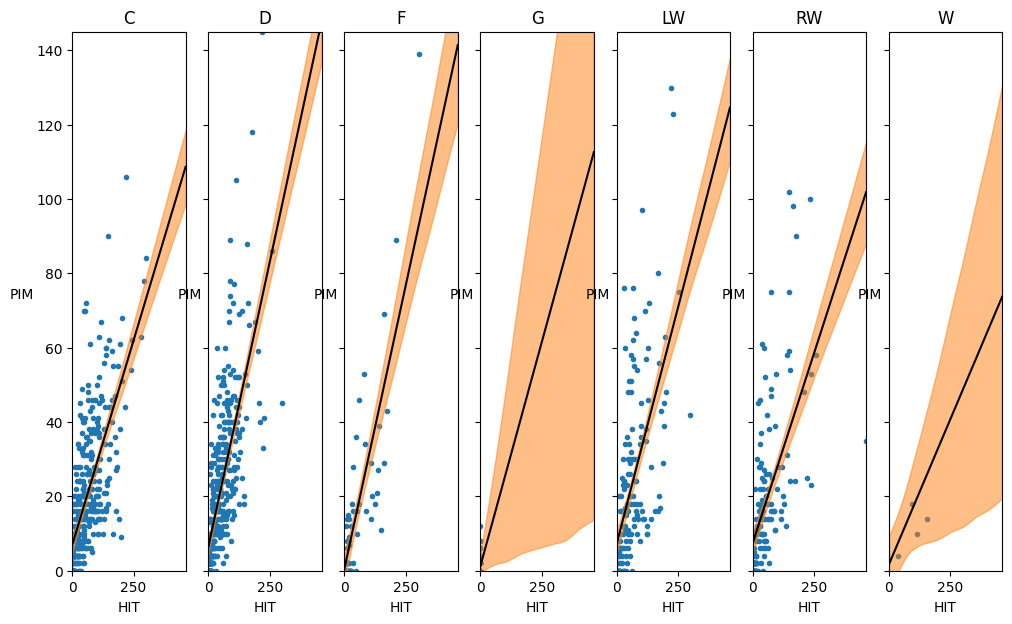

In [ ]:
#set up plots
_, ax = plt.subplots(1, 7, figsize=(12, 7), sharex=True, sharey=True)
ax = np.ravel(ax)
#x values for putting through our linear equation, in order to graph the line
x_range = np.linspace(hockey_data['HIT'].min(), hockey_data['HIT'].max(), 10)
#grab the posterior
posterior = az.extract(idata_hoff)

#plot all 12 lines against the data
for i, p in enumerate(pos_codes):
    #plot raw data
    ax[i].scatter(
        x = hockey_data.query('Pos == @p')['HIT'],
        y = hockey_data.query('Pos == @p')['PIM'],
        marker=".")
    #titles and labels
    ax[i].set_title(f"{p}")
    ax[i].set_xlabel("HIT")
    ax[i].set_ylabel("PIM", labelpad=10, rotation=0)
    #grab posterior info
    alphas = posterior["α"].sel(pos=p)
    betas = posterior["β"].sel(pos=p)
    alpha_m = alphas.mean("sample").item()
    beta_m = betas.mean("sample").item()
    #plot the posterior
    ax[i].plot(x_range, alpha_m + beta_m * x_range, c="k")
    az.plot_hdi(x_range, alphas + betas * xr.DataArray(x_range).transpose(), ax=ax[i])
    #set window size
    plt.xlim(hockey_data['HIT'].min() - 0.01, hockey_data['HIT'].max() + 0.01)
    plt.ylim(hockey_data['PIM'].min() - 0.01, hockey_data['PIM'].max() + 0.01)

Overall there doesn't seem to be a correlation for goal keepers and wingers, the linear variable variance model would not run and doesn't really fit the model very well, and I couldn't figure out another linear model that would encompass the data, but it seems to be that there is some correlation for the other individual positions, just by visually looking at the data.

# Conclusion

There is a correlation between legal hits and minutes in the penalty box for 24 25 NHL hockey players. There may be some correlation within the positions as well, excluding goalkeepers and wingers.